In [1]:
import gym
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from navigation_gym.tasks.navigation_discrete_task import NavigationDiscreteTask

Instructions for updating:
non-resource variables are not supported in the long term


## Register Environment

In [2]:
env = gym.make('Navigation-v0')

print("Observation Space: {}".format(env.observation_space))
print("Action Space: {}".format(env.action_space))

/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-navigation/navigation_gym/src/navigation_gym/tasks/navigation_discrete_task.py:25: UserWarning: 'rl-navigation_38161_1615201370040' is not a legal ROS base name. This may cause problems with other ROS tools.
  rospy.init_node('rl-navigation', anonymous=True, log_level=rospy.INFO)
[ERROR] [1615201370.205416, 49.053000]: NOT Initialising Simulation Physics Parameters
[WARN] [1615201370.209251, 0.004000]: Start Init ControllersConnection
[WARN] [1615201370.210133, 0.004000]: END Init ControllersConnection


Observation Space: Box(0.0, 1.0, (84, 84, 4), float32)
Action Space: Discrete(3)


## Check Environment State

0.0
1.0


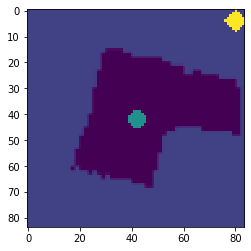

In [3]:
obs = env.reset()
for _ in range(4):
    obs, _, _, _ = env.step(action=2)
plt.imshow(obs[:, :, 0])
print(obs.min())
print(obs.max())

## Ray Configs

In [4]:
config = {
    "env": NavigationDiscreteTask,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    "num_gpus": 1,
    "num_workers": 1,
    #"model": {"dim": 84,
    #          "conv_filters":
    #              [[16, [3, 3], 2], [32, [3, 3], 2], [64, [3, 3], 2], [128, [11, 11], 1]]}
}

stop = {
    "episodes_total": 6000,
}

In [5]:
ray.init()

2021-03-08 12:03:02,187	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.60',
 'raylet_ip_address': '192.168.178.60',
 'redis_address': '192.168.178.60:6379',
 'object_store_address': '/tmp/ray/session_2021-03-08_12-03-01_672961_38161/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-08_12-03-01_672961_38161/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-08_12-03-01_672961_38161',
 'metrics_export_port': 62999,
 'node_id': 'd779cd3582389779c272e9d5a8134aa5e39fc347'}

## Train

In [6]:
def train(stop_criteria, config):
    analysis = ray.tune.run(PPOTrainer, config=config,
                            stop=stop_criteria,
                            checkpoint_freq=1,
                            checkpoint_at_end=True)
    # list of lists: one list per checkpoint; each checkpoint list contains 1st the path, 2nd the metric value
    checkpoints = analysis.get_trial_checkpoints_paths(trial=analysis.get_best_trial('episode_reward_mean', mode='max'),
                                                       metric='episode_reward_mean',
                                                       )
    # retriev the checkpoint path; we only have a single checkpoint, so take the first one
    checkpoint_path = checkpoints[0][0]
    return checkpoint_path, analysis

def load(checkpoint_path, config):
    """
    Load a trained RLlib agent from the specified path. Call this before testing a trained agent.
    :param path: Path pointing to the agent's saved checkpoint (only used for RLlib agents)
    """
    agent = PPOTrainer(config=config)
    agent.restore(checkpoint_path)
    return agent

def test(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    return episode_reward

def test_traj(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    positions = []
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        positions.append(info['position'])
        episode_reward += reward

    return episode_reward, positions

In [ ]:
checkpoint_path, analysis = train(stop_criteria=stop,
                                  config=config)


Trial name,status,loc
PPO_NavigationDiscreteTask_ab2b5_00000,RUNNING,


(pid=37640) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=37640) Instructions for updating:
(pid=37640) non-resource variables are not supported in the long term
(pid=37640) 2021-03-08 12:01:47,620	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=37640) 2021-03-08 12:01:47,620	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=37642) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=37642) Instructions for updating:
(pid=37642) non-resource variables a